# 데이콘 BaseLine 위주 + 파이토치 도서(model) + 데이터 증강
PUBLIC 점수 : 0.8785

In [28]:
import torch
import torch.nn.init
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim # 최적화 알고리즘들이 포함힘
import torch.nn as nn # 신경망들이 포함됨

import os
import random
import numpy as np
from glob import glob
import re
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [30]:
print(device)

cuda


# BaseLine과의 차이점
CFG에서 IMG_SIZE를 128에서 32로 줄임, LEARNING_RAGE를 1e-3으로 수정

In [31]:
#하이퍼 파라미터 튜닝

CFG = {
    'IMG_SIZE':32, # baseline 이미지 사이즈 128
    'EPOCHS':50, #에포크
    'LEARNING_RATE':1e-3, #학습률
    'BATCH_SIZE':12, #배치사이즈 # 처음엔12
    'SEED':41, #시드
}

In [32]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [33]:
import pandas as pd
label_df = pd.read_csv('user_data/train.csv')
label_df.head()

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [34]:
label_df['label'][label_df['label'] == '10-1'] = 10 ## label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0 ## Label : 10-2 -> 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ## Dtype : object -> int

# BaseLine과의 차이점
파일 경로 에러나서 re모듈 이용하여 \\ -> /로 수정

In [35]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend([re.sub('\\\\','/',i) for i in glob(os.path.join(data_dir, '*.png'))])
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend([re.sub('\\\\','/',i) for i in glob(os.path.join(data_dir, '*.png'))])
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    
    return img_path_list

In [36]:
all_img_path, all_label = get_train_data('user_data/train')
test_img_path = get_test_data('user_data/test')

# CustomDataset

In [37]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        
    
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

In [38]:
# Train : Validation = 0.8 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

# BaseLine과의 차이점
RandomHorizontalFlip(좌우변경), RandomRotation(각도 랜덤), RandomPerspective(원근법?) 추가하여 데이터 증강때 사용  
제출당시 RandomRotation, RandomPerspective 하이퍼파라미터 정확히 기억은 안나지만 (10, 0.1 or 15,0.15) 둘중 하나 였습니다.

In [39]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.RandomHorizontalFlip(), # Horizontal Flip
                    # transforms.RandomCrop(32, padding=2), # Centre Crop 이거 하면 오히려 점수 잘 안나옴
                    transforms.RandomRotation(degrees=10,interpolation=transforms.InterpolationMode.NEAREST),
                    transforms.RandomPerspective(distortion_scale=.15,p=.15,interpolation=transforms.InterpolationMode.NEAREST),
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

# Dataloader

# BaseLine과의 차이점
데이터 증강 이렇게 하는지는 잘 모르겠지만 total train batches 개수 보니까 데이터 수 증가된것으로 보입니다.

In [40]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) ## 맨 처음 선언 안하면 오류뜸
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)

for i in range(10): ## 데이터 수 10배 증가 (100배로 증가시키고나서 진행해봤지만 성능은 더 안좋아졌습니다. 0.78정도)
    train_dataset+=CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
    vali_dataset += CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
    
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [41]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches) ## 643개의 이미지 이용, 총 배치 개수 54 -> 643개의 이미지 이용, 총 배치 개수 590
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 590
total valid imgs : 214 / total valid batches : 198


# 이미지 및 shape 확인

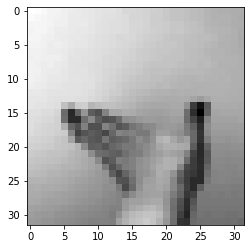

Label: 9


In [42]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

# BaseLine과의 차이점
모델 조금 수정함, pytorch 관련 도서 참고

In [43]:
class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.keep_prob = 0.5 ## dropout에서 쓰임
        self.layer1 = torch.nn.Sequential(
            ##채널=1
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)) ## 절반으로 줄어듬
        
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 363, bias=True)
        # torch.nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(), ##ReLU Sigmoid
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        self.fc2 = torch.nn.Linear(363, 11, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out
        

In [44]:
# CNN 모델 정의
model = CNNclassification().to(device)

In [45]:
criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.Adam(model.parameters(), lr=CFG["LEARNING_RATE"])

In [46]:
model = CNNclassification().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

# BaseLine과의 차이점
tqdm부분만 제거 (성능에 영향X)

In [47]:
def train(model, optimizer, train_loader, scheduler, device): 
    model.to(device)
    n = len(train_loader)
    
    #Loss Function 정의
    criterion = nn.CrossEntropyLoss().to(device)
    best_acc = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
            
        for img, label in iter(train_loader): # tqdm
            img, label = img.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(img) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
              
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))
        
        if scheduler is not None:
            scheduler.step()
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for img, label in iter(vali_loader): # tqdm
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(vali_loader.dataset)
        print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset))) 
        
        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc
            torch.save(model.state_dict(), './saved/best_model.pth') #이 디렉토리에 best_model.pth을 저장
            # print('Model Saved.')

In [48]:
train(model, optimizer, train_loader, scheduler, device)

[1] Train loss: 2.3907265291
Vail set: Loss: 2.0106, Accuracy: 517/2365 ( 22%)

[2] Train loss: 1.8780648547
Vail set: Loss: 1.6524, Accuracy: 781/2365 ( 33%)

[3] Train loss: 1.6771081167
Vail set: Loss: 1.4683, Accuracy: 869/2365 ( 37%)

[4] Train loss: 1.5520667015
Vail set: Loss: 1.3219, Accuracy: 1056/2365 ( 45%)

[5] Train loss: 1.4576763640
Vail set: Loss: 1.2042, Accuracy: 1287/2365 ( 54%)

[6] Train loss: 1.3388714004
Vail set: Loss: 1.0859, Accuracy: 1397/2365 ( 59%)

[7] Train loss: 1.2803874508
Vail set: Loss: 0.9395, Accuracy: 1573/2365 ( 67%)

[8] Train loss: 1.2113900319
Vail set: Loss: 1.0306, Accuracy: 1507/2365 ( 64%)

[9] Train loss: 1.1688589824
Vail set: Loss: 0.9304, Accuracy: 1639/2365 ( 69%)

[10] Train loss: 1.1289709547
Vail set: Loss: 1.0247, Accuracy: 1441/2365 ( 61%)

[11] Train loss: 1.1043160557
Vail set: Loss: 0.9215, Accuracy: 1595/2365 ( 67%)

[12] Train loss: 1.0646186306
Vail set: Loss: 0.8514, Accuracy: 1716/2365 ( 73%)

[13] Train loss: 1.049573533

In [49]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [50]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./saved/best_model.pth')
model = CNNclassification().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/18 [00:00<?, ?it/s]

[1, 2, 1, 6, 8]

In [51]:
submission = pd.read_csv('user_data/sample_submission.csv')
submission['label'] = preds

In [52]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

In [53]:
submission.head(10)

,file_name,label
0,001.png,1
1,002.png,2
2,003.png,1
3,004.png,6
4,005.png,8
5,006.png,10-1
6,007.png,10-1
7,008.png,2
8,009.png,4
9,010.png,4


In [28]:
submission.to_csv('./제출/submit_TAVE_MJei_code.csv', index=False) ## -> PUBLIC 점수 0.8785